# LAB 1b - ANNDA

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch import nn
from tqdm import trange

In [38]:
# Auxiliary variables
colors = ['#1E90FF','#FF69B4']

# NEURAL NETWORK CLASS
class NeuralNetwork(nn.Module) :
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size) :
        super(NeuralNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.output_size = output_size
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size_1),
            nn.Sigmoid(),
            nn.Linear(hidden_size_1, hidden_size_2),
            nn.Sigmoid(),
            nn.Linear(hidden_size_2, output_size)
        )

    def forward(self, x):
        y = self.linear_relu_stack(x)
        return y
        
    def initialize_weights(self):
        for layer in self.Sequential.children():
            # Initiliazing with Xavier Normal
            nn.init.xavier_normal_(layer.weight)

    def train(self,lr,n_epochs,loss_fn,X_train_ten,T_train_ten,X_valid_ten,T_valid_ten) :
        mses, mses_valid = [], []
        optim = torch.optim.Adam(self.parameters(),lr=lr)
        for epoch in range(n_epochs):
            #forward feed
            T_pred_train_ten = self.forward(X_train_ten.requires_grad_())
            #calculate the loss
            loss = loss_fn(T_pred_train_ten, T_train_ten)
            mses.append(loss.item())

            #forward validation
            T_pred_valid_ten = self.forward(X_valid_ten)
            #calculate the validation loss
            loss_valid = loss_fn(T_pred_valid_ten, T_valid_ten)
            mses_valid.append(loss_valid.item())
            
            #backward propagation: calculate gradients
            loss.backward()
            #update the weights
            optim.step()
            #clear out the gradients from the last step loss.backward()
            optim.zero_grad()
        return mses, mses_valid, T_pred_train_ten, T_pred_valid_ten

    def show(self) :
        print('--------------------------------------------------\n')
        print('Neural Network Description')
        print('Input Layer Neurons = ',self.input_size)
        print('Hidden Layer 1 Neurons = ',self.hidden_size_1)
        print('Hidden Layer 2 Neurons = ',self.hidden_size_2)
        print('Output Layer Neurons = ',self.output_size,'\n')
        print(self)
        print('\n--------------------------------------------------\n')


# HELPER FUNCTIONS
def gen_mackey_glass_series(beta, tau, gamma, n, N) :
    x = [1.5]
    for t in range(1,N+1) :
        x_tau = x[t-tau] if t >= tau else 0
        x.append((1-gamma)*x[t-1] + (beta*x_tau)/(1 + x_tau**n))
        if (t >= 25) and (t <= N) :
            X_col = np.array([[x[t-25],x[t-20],x[t-15],x[t-10],x[t-5]]])
            T_col = np.array([[x[t]]])
            X = X_col if t == 25 else np.append(X,X_col,axis=0)
            T = T_col if t == 25 else np.append(T,T_col,axis=0)

    return x, X.T, T.T

def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.fill_(1.0)

def plot_error(errors,errors_valid,title) :
    fig, ax = plt.subplots()
    ax.grid(visible = True)
    ax.set_title(title+' over epochs')
    ax.plot(errors,label='Training')
    ax.plot(errors_valid,label='Validation')
    ax.legend()
    ax.set_xlabel('Epoch')
    ax.set_ylabel(title)
    plt.show()

def plot_series(series,series_pred,title) :
    fig, ax = plt.subplots()
    ax.grid(visible = True)
    ax.set_title(title)
    ax.plot(series,label='True')
    ax.plot(series_pred,label='Predicted')
    ax.legend()
    ax.set_xlabel('t')
    ax.set_ylabel('x(t)')
    plt.show()

def plot_archs_comparison(combs,combs_mean_mses,combs_mean_mses_valid,combs_gen_error) :
    plotdata = pd.DataFrame({
        'Training':combs_mean_mses,
        'Validation':combs_mean_mses_valid,
        'Gen. Error':combs_gen_error
        }, 
        index=combs
    )
    plotdata.plot(kind='bar', stacked=True)

def compare_archs(lr,n_epochs,loss_fn,X_train_ten,T_train_ten,X_valid_ten,T_valid_ten,input_size,output_size,hidden_sizes_1,hidden_sizes_2,patience) :
    combs, early_stop, mses_final,mses_valid_final = [],[],[],[]
    # For each of the combinations
    for hidden_size_1 in hidden_sizes_1 :
        for hidden_size_2 in hidden_sizes_2 :
            model = NeuralNetwork(input_size, hidden_size_1, hidden_size_2, output_size)
            model.apply(init_weights)
            mses, mses_valid, T_pred_train_ten, T_pred_valid_ten = model.train(lr,n_epochs,loss_fn,X_train_ten,T_train_ten,X_valid_ten,T_valid_ten)

            # new_bin = np.array(mses_valid[0:patience])
            new_bin = mses_valid[0:patience]
            decreasing = True
            i = 0
            while decreasing:
                i = i + 1
                last_error = new_bin[0]
                new_bin = new_bin[1:]
                new_bin = np.concatenate((new_bin,mses_valid[int(patience+i)]),axis=0)
                
                decreasing = True in (new_bin < last_error)
            
            combs.append(str(hidden_size_1)+'+'+str(hidden_size_2))
            early_stop.append(i)
            mses_final.append(mses[i])
            mses_valid_final.append(mses_valid[i])

    

    return combs, early_stop, mses_final,mses_valid_final

### Define architecture and learning params


In [39]:
# Generate data according to Mackey Glass time series
beta = 0.2
tau = 25
gamma = 0.1
n = 10
N = 2000
x,X,T = gen_mackey_glass_series(beta,tau,gamma,n,N)

# Obtain a subdivision of generated data
X_samples = X[:,301:1501]
T_samples = T[:,301:1501]

#Split data
X_train = X_samples[:,:600]
X_valid = X_samples[:,600:1000]
X_test = X_samples[:,1000:]
T_train = T_samples[:,:600]
T_valid = T_samples[:,600:1000]
T_test = T_samples[:,1000:]

# Convert data to tensors
X_train_ten = torch.tensor(X_train.T,dtype=torch.float)
T_train_ten = torch.tensor(T_train.T,dtype=torch.float)
X_valid_ten = torch.tensor(X_valid.T,dtype=torch.float)
T_valid_ten = torch.tensor(T_valid.T,dtype=torch.float)
X_test_ten = torch.tensor(X_test.T,dtype=torch.float)
T_test_ten = torch.tensor(T_test.T,dtype=torch.float)

In [40]:
## Neural Network Dimensions
input_size, output_size = 5, 1

# Define loss and optimizer
lr = 0.005
n_epochs = 5000
patience = 7
mseloss = nn.MSELoss()

hidden_sizes_1 = [3,4,5]
hidden_sizes_2 = [2,4,6]

In [44]:
# Compare models

combs, early_stop, mses_final,mses_valid_final = compare_archs(lr,n_epochs,mseloss,X_train_ten,T_train_ten,X_valid_ten,T_valid_ten,input_size,output_size,hidden_sizes_1,hidden_sizes_2,patience)
#combs_gen_error = [combs_mean_mses_valid[i]-combs_mean_mses[i] for i in range(9)]

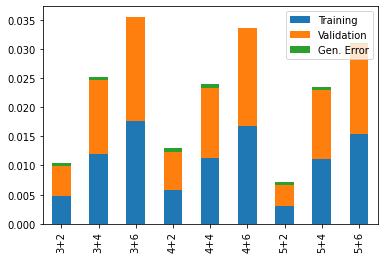

In [ ]:
# Plot models comparison
lab1b_torch.plot_archs_comparison(combs,combs_mean_mses,combs_mean_mses_valid,combs_gen_error)

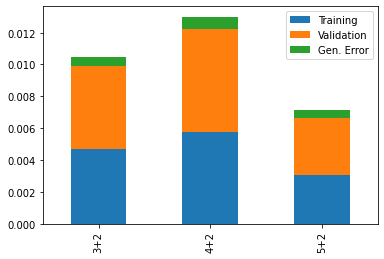

In [ ]:
# Plot models comparison
best_combs = [combs[i] for i in range(0,9,3)]
best_combs_mean_mses = [combs_mean_mses[i] for i in range(0,9,3)]
best_combs_mean_mses_valid = [combs_mean_mses_valid[i] for i in range(0,9,3)]
best_combs_gen_error = [combs_gen_error[i] for i in range(0,9,3)]
lab1b_torch.plot_archs_comparison(best_combs,best_combs_mean_mses,best_combs_mean_mses_valid,best_combs_gen_error)

## BEST MODEL

In [ ]:
# Train model
hidden_size_1 = hidden_sizes_1[2]
hidden_size_2 = hidden_sizes_2[0]
model = lab1b_torch.NeuralNetwork(input_size, hidden_size_1, hidden_size_2, output_size)
mses, mses_valid, T_pred_train_ten, T_pred_valid_ten = model.train(lr,n_epochs,mseloss,X_train_ten,T_train_ten,X_valid_ten,T_valid_ten)

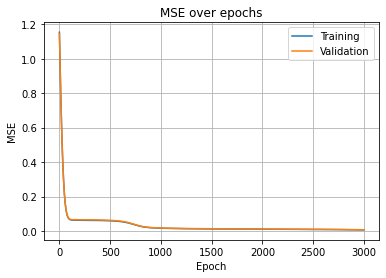

In [ ]:
lab1b_torch.plot_error(mses,mses_valid,'MSE')

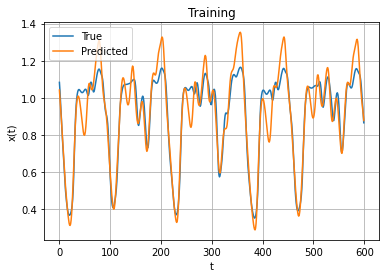

In [ ]:
lab1b_torch.plot_series(T_pred_train_ten.detach().numpy().T.reshape(-1),T_train.reshape(-1),'Training')

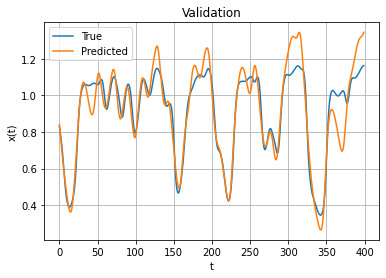

In [ ]:
lab1b_torch.plot_series(T_pred_valid_ten.detach().numpy().T.reshape(-1),T_valid.reshape(-1),'Validation')

## WORST MODEL

In [ ]:
# Train model
hidden_size_1 = hidden_sizes_1[1]
hidden_size_2 = hidden_sizes_2[2]
model = lab1b_torch.NeuralNetwork(input_size, hidden_size_1, hidden_size_2, output_size)
mses, mses_valid, T_pred_train_ten, T_pred_valid_ten = model.train(lr,n_epochs,mseloss,X_train_ten,T_train_ten,X_valid_ten,T_valid_ten)

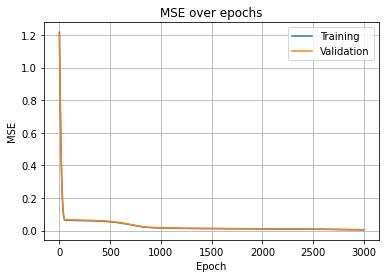

In [ ]:
lab1b_torch.plot_error(mses,mses_valid,'MSE')

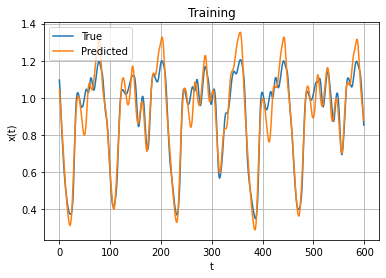

In [ ]:
lab1b_torch.plot_series(T_pred_train_ten.detach().numpy().T.reshape(-1),T_train.reshape(-1),'Training')

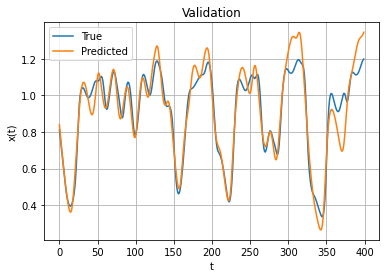

In [ ]:
lab1b_torch.plot_series(T_pred_valid_ten.detach().numpy().T.reshape(-1),T_valid.reshape(-1),'Validation')